In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import lal
import bilby
import numpy as np
from pycbc.waveform import get_td_waveform, taper_timeseries
import pycbc.types
import pylab
import pycbc.noise
import pycbc.psd
from gwmat import point_lens
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
import gwmat
import os
import sys
from pycbc.detector.ground import Detector
from pathlib import Path

import bilby
from bilby.core.likelihood import GaussianLikelihood
from bilby.core.prior import Uniform

import corner

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from nflows.flows import Flow
from nflows.distributions import StandardNormal
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms import CompositeTransform, RandomPermutation

In [54]:
num_samples = 50
f_lower = 5.0       

priors = bilby.core.prior.PriorDict()

priors["mass1"] = bilby.core.prior.Constraint(name="mass1", minimum=10, maximum=100)
priors["mass2"] = bilby.core.prior.Constraint(name="mass2", minimum=10, maximum=100)
priors['mass_ratio'] = bilby.gw.prior.UniformInComponentsMassRatio(name='mass_ratio', minimum=0.2, maximum=10)
priors['chirp_mass'] = bilby.gw.prior.UniformInComponentsChirpMass(name='chirp_mass', minimum=25, maximum=100)
priors['spin1z'] = bilby.core.prior.Uniform(name='spin1z', minimum=0.0, maximum=0.9)
priors['spin2z'] = bilby.core.prior.Uniform(name='spin2z', minimum=0.0, maximum=0.9)
priors['eccentricity'] = bilby.core.prior.Uniform(name='eccentricity', minimum=0.1, maximum=0.6)
priors['coa_phase'] = bilby.core.prior.Uniform(name='coa_phase', minimum=0.0, maximum=2 * np.pi)
priors['distance'] = bilby.core.prior.Uniform(name='distance', minimum=100, maximum=1000)
priors['dec'] = bilby.core.prior.Cosine(minimum=-np.pi/2, maximum=np.pi/2)
priors['ra'] = bilby.core.prior.Uniform(minimum=0., maximum=2*np.pi, boundary="periodic")
priors['polarization'] = bilby.core.prior.Uniform(minimum=0., maximum=np.pi, boundary="periodic")

priors['Log_Mlz'] = bilby.core.prior.Uniform(minimum = 3, maximum = 5)
priors['yl'] = bilby.core.prior.PowerLaw(alpha = 1, minimum = 0.01, maximum = 1.0)

parameters_list = priors.sample(num_samples)

samples = [
    {key: parameters_list[key][i] for key in parameters_list}
    for i in range(num_samples)
]

print(f"Length of parameters_list: {len(samples)}")

Length of parameters_list: 50


In [55]:
def waveform(num):
    parameters = samples[num].copy()

    mass1, mass2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(parameters['chirp_mass'], parameters['mass_ratio'])

    m_lens = np.power(10., parameters.pop("Log_Mlz"))
    y_lens = parameters.pop("yl")

    sp, sc = get_td_waveform(
        approximant='teobresums',
        mass1=mass1,
        mass2=mass2,
        lambda1=0,
        lambda2=0,
        spin1z=parameters['spin1z'],
        spin2z=parameters['spin2z'],
        distance=parameters['distance'],
        delta_t=1.0 / 4096 ,
        ecc=0,
        coa_phase=parameters['coa_phase'],
        f_lower=5,
    )

    ####---------------------Generating Lensed Waveform--------------------####

    sp_freq = sp.to_frequencyseries(delta_f = sp.delta_f)
    sc_freq = sc.to_frequencyseries(delta_f = sc.delta_f)

    fs1 = sp_freq.sample_frequencies
    assert np.allclose(fs1, sc_freq.sample_frequencies), "Sample frequencies do not match!"

    Ffs_sp = np.vectorize(lambda f: gwmat.cythonized_point_lens.Ff_effective(f, ml=m_lens, y=y_lens))(fs1)
        
    time_Delay = point_lens.time_delay(ml=m_lens, y=y_lens)

    sp_lensed = pycbc.types.FrequencySeries(np.conj(Ffs_sp) * np.asarray(sp_freq), delta_f=sp_freq.delta_f).cyclic_time_shift(-1 * (0.1 + time_Delay))
    sc_lensed = pycbc.types.FrequencySeries(np.conj(Ffs_sp) * np.asarray(sc_freq), delta_f=sc_freq.delta_f).cyclic_time_shift(-1 * (0.1 + time_Delay))

    sp_lensed = sp_lensed.to_timeseries(delta_t=sp_lensed.delta_t)
    sc_lensed = sc_lensed.to_timeseries(delta_t=sc_lensed.delta_t)


    ####---------------------Projecting on detector--------------------####

    detector = Detector('H1')

    lensed_signal = detector.project_wave(sp_lensed, sc_lensed, ra = parameters['ra'], dec = parameters['dec'], polarization = parameters['polarization'])

    return np.array(lensed_signal)

In [56]:
def simulator(num):
    return 1e1 * np.random.normal(size=waveform(num).shape) * max(waveform(num)) + waveform(num), list(samples[num].values())

In [78]:
num_simulations = 50
theta_vals = []
data_vals = []
for ii in range(num_simulations):
    y_val, theta_val = simulator(ii)
    data_vals.append(y_val)
    theta_vals.append(theta_val)

In [79]:
# for i, d in enumerate(data_vals):
#     print(f"Index {i}: shape = {np.shape(d)}")

from torch.nn.utils.rnn import pad_sequence

# Convert your data to tensors if not already
tensor_vals = [torch.tensor(d, dtype=torch.float32) for d in data_vals]

# Pad to the same length (default padding value is 0.0)
# This returns a tensor of shape (max_length, batch_size)
padded = pad_sequence(tensor_vals, batch_first=True)

data_vals = padded.numpy()

In [80]:
# convert to torch tensors
theta_vals = torch.from_numpy(np.array(theta_vals)).to(torch.float32)
data_vals = torch.from_numpy(np.array(data_vals)).to(torch.float32)

# create dataset
class DataGenerator(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return theta_vals[idx], data_vals[idx]

dataset = DataGenerator()

# create dataloaders - 80/10/10 split
train_set_size = int(0.8 * num_simulations)
val_set_size = int(0.1 * num_simulations)
test_set_size = int(0.1 * num_simulations)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

train_data_loader = DataLoader(
    train_data, batch_size=2,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=2,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

In [81]:
len(train_data_loader), len(val_data_loader), len(test_data_loader)

(20, 3, 5)

In [82]:
num_transforms = 5
num_blocks = 8
hidden_features = 50

context_features = padded.shape[1]  # because 100 data points

base_dist = StandardNormal([12])  # because 2-D posterior

transforms = []

for _ in range(num_transforms):
    block = [
        MaskedAffineAutoregressiveTransform(
                features=12,  # 2-dim posterior
                hidden_features=hidden_features,
                context_features=context_features,
                num_blocks=num_blocks,
                activation=torch.tanh,
                use_batch_norm=False,
                use_residual_blocks=False,
        ),
        RandomPermutation(features=12)
    ]
    transforms += block

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)

In [83]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [84]:
for i in range(100):
    for idx, val in enumerate(train_data_loader):
        theta, data = val
        
        optimizer.zero_grad()
        loss = -flow.log_prob(theta, context=data).mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
    if i % 10 == 0:
        print(f"Epoch {i} Loss: {loss.item()}")

Epoch 0 Loss: 6655.90380859375
Epoch 10 Loss: 868.900146484375
Epoch 20 Loss: 119.40739440917969
Epoch 30 Loss: 44.82402801513672
Epoch 40 Loss: 41.64081573486328
Epoch 50 Loss: 50.31662368774414
Epoch 60 Loss: 20.590003967285156
Epoch 70 Loss: 20.277637481689453
Epoch 80 Loss: 22.239744186401367
Epoch 90 Loss: 18.689899444580078


In [86]:
test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=True
)

theta_test, data_test = next(iter(test_data_loader))
with torch.no_grad():
        samples = flow.sample(5000, context=data_test.reshape((1, 138005)))



theta_test = theta_test.squeeze(0)

In [87]:
theta_test

tensor([2.5534e+00, 7.3727e+01, 7.4989e-01, 9.5921e-02, 2.2103e-01, 4.5110e+00,
        8.0350e+02, 6.5751e-01, 5.6530e+00, 2.7588e+00, 4.6703e+00, 6.7606e-01])

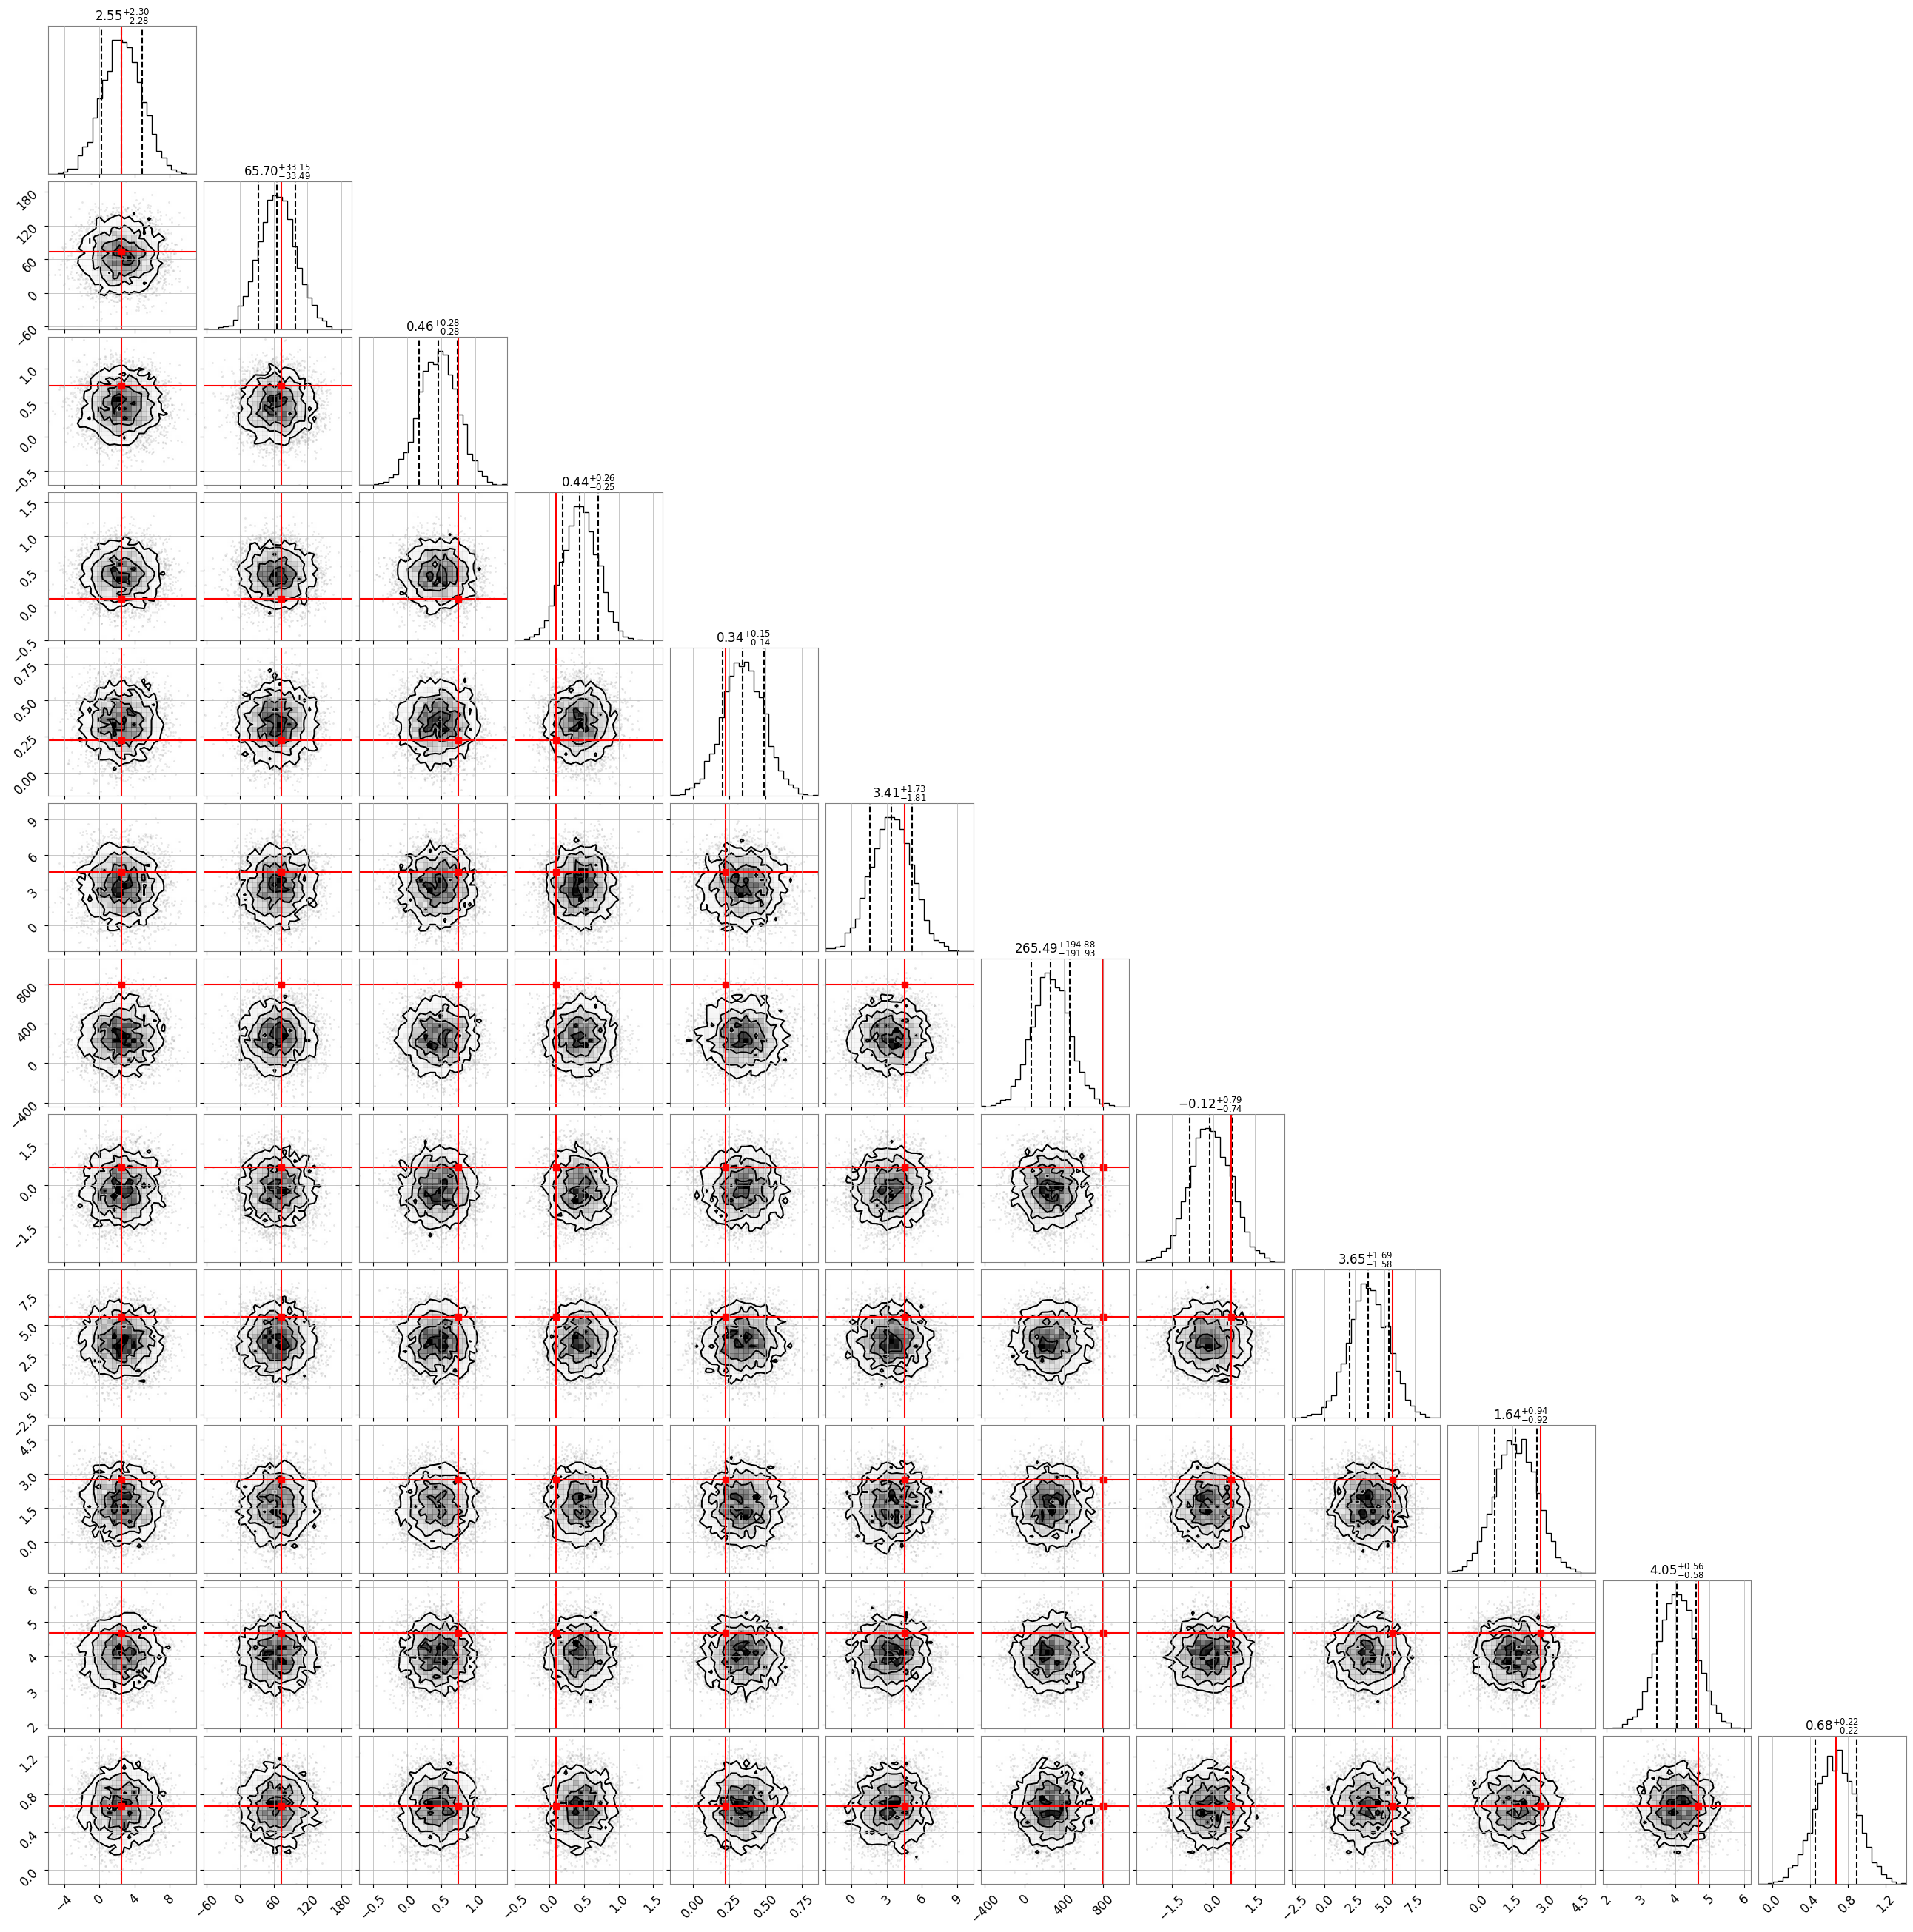

In [93]:
data = samples.squeeze(0).numpy() 

# Generate the corner plot
figure = corner.corner(
    data,
    bins=30,  # Number of bins
    # labels=["m", "c"],
    quantiles=[0.16, 0.5, 0.84],  # Show median and 1-sigma
    show_titles=True,
    title_kwargs={"fontsize": 12},
    truths=theta_test.numpy(),
    truth_color="red",
)

# Show the plot
# plt.axvline(x=0, color='k', linestyle='--')
plt.show()